## AskStreets: Query and Visualizing Street Networks using OpenStreetMap, ArangoDB, and LangGraph
Author: Adam Munawar Rahman, March 2025

Using powerful libraries like OSMnx, we can retrieve street networks and feature datasets from OpenStreetMap and persist them as graph and collections in ArangoDB. Then, with a  ReACT agent model, feed natural language queries to LLMs to execute complex lookups, run GPU backed graph algorithms, and visualize geospatial coordinates - all to enable streamlined insights into the network properties of the geographic area we are analyzing.

In [59]:
import json
import os
import random
import re
import time
import traceback
import yaml

import folium
import geopandas as gpd

%env NX_CUGRAPH_AUTOCONFIG=True
import networkx as nx
import numpy as np
import nx_arangodb as nxadb
import osmnx as ox
import pandas as pd

from arango import ArangoClient
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from IPython.display import Markdown, display

from langchain.tools import Tool
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs import ArangoGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_ibm import ChatWatsonx
from langgraph.prebuilt import create_react_agent

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

env: NX_CUGRAPH_AUTOCONFIG=True


In [60]:
!nvidia-smi
!nvcc --version

Sat Mar  8 11:21:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:09:00.0  On |                  N/A |
| 20%   32C    P8             21W /  215W |    1640MiB /   8192MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [61]:
nx.config.backends.arangodb.use_gpu = True
nx.config.warnings_to_ignore.add("cache")

### I. Loading OpenStreetMap Networks and Features to ArangoDB
We can retrieve both street networks (consisting of nodes and edges representing the different types of paths that can be traversed between the geographic locations) and features (consisting of points associated with specific attributes like amenity type) by calling `ox.graph_from_address` and `ox.features_from_address`. 

In this instance, I'm using my workplace in NYC - IBM at One Madison  Avenue - to build our datasets from.

In [86]:
# Retrieve the street network from OpenStreetMap using the built-in OSMnx function
G_ox = ox.graph_from_address("1 Madison Ave, Manhattan, NY", dist=250.0)

# # Drop the shapely.Linestring attribute as it is not serializable to JSON, preventing ArangoDB persistence
for node1, node2, edge_dict in G_ox.edges(data=True):
    edge_dict.pop('geometry', None)
    
print(f"Graph of street network within a 250 meter radius of One Madison Avenue: {G_ox}")

Graph of street network within a 250 meter radius of One Madison Avenue: MultiDiGraph with 330 nodes and 922 edges


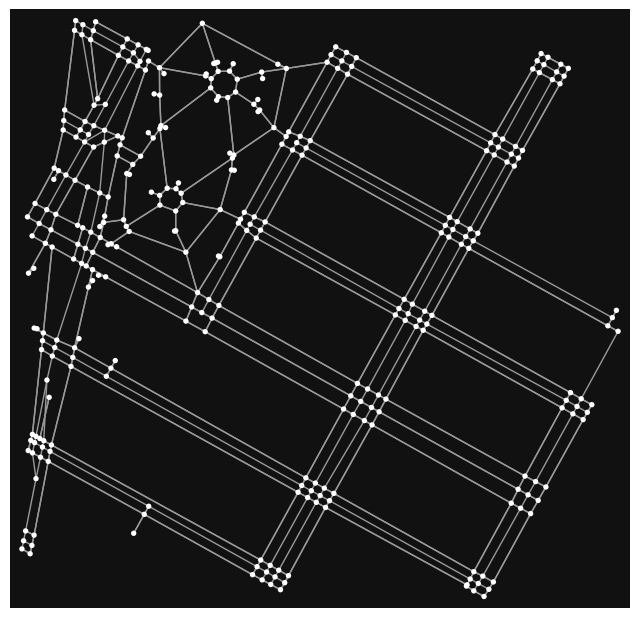

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [87]:
ox.plot_graph(G_ox)

In [89]:
# Since the nodes in the OSMnx graph do not include the address, we geocode each node
geolocator = Nominatim(user_agent="osmnx_geocoder")
for node_id, node_data in G_ox.nodes(data=True):
    lat = node_data['y']
    lon = node_data['x']
    
    try:
        # Use reverse geocoding on points to get address information
        location = geolocator.reverse(f"{lat}, {lon}", exactly_one=True, timeout=None)
        if location:
            # Add address information to the node
            G_ox.nodes[node_id]['address'] = location.address

        # Avoid possible rate limiting by waiting a bit between each node
        time.sleep(1)

    except Exception as e:
        print(f"Error geocoding node {node_id}: {e}")

In [90]:
# The node identifiers change when persisting the graph to ArangoDB, so to allow the tools to better communicate with each other,
# e.g. when passing OSMnx results to the AQL tool, let's include current NetworkX node IDs so ArangoDB can access them
for node_id, node_data in G_ox.nodes(data=True):
    G_ox.nodes[node_id]['ID'] = node_id

In [91]:
madison_filepath = "./data/madison.graphml"

In [122]:
# Save street network graph 
ox.io.save_graphml(G_ox, madison_filepath)

In [93]:
# Load street network graph from saved file
G_ox = ox.io.load_graphml(madison_filepath)

In [94]:
node_list_with_addresses = list(G_ox.nodes(data=True))
print(f"Sample node data with address: {node_list_with_addresses[0]}")
print(f"Sample node data with address: {node_list_with_addresses[65]}")
print(f"Sample node data with address: {node_list_with_addresses[120]}")
print(f"Sample node data with address: {node_list_with_addresses[34]}")

edge_list = list(G_ox.edges(data=True))
print(f"Sample edge data: {edge_list [0]}")
print(f"Sample edge data: {edge_list [65]}")
print(f"Sample edge data: {edge_list [120]}")
print(f"Sample edge data: {edge_list [34]}")

Sample node data with address: (42428183, {'y': 40.7391688, 'x': -73.9897506, 'street_count': 4, 'address': '902, Broadway, Flatiron District, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10010, United States', 'ID': '42428183'})
Sample node data with address: (3857400399, {'y': 40.7428919, 'x': -73.988616, 'highway': 'crossing', 'street_count': 4, 'address': '202, 5th Avenue, NoMad, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10010, United States', 'ID': '3857400399'})
Sample node data with address: (8268734921, {'y': 40.7428499, 'x': -73.9885165, 'street_count': 1, 'address': 'Flatiron District, Manhattan Community Board 5, Manhattan, New York County, City of New York, New York, 10010, United States', 'ID': '8268734921'})
Sample node data with address: (3008856924, {'y': 40.7427708, 'x': -73.9887096, 'highway': 'crossing', 'street_count': 4, 'address': '5th Avenue, Flatiron District, Manhattan Community 

In [16]:
# Retrieve OpenStreet map features within the area of the street network that we just received
# Refer to https://wiki.openstreetmap.org/wiki/Map_features for the specific features

# Collecting a large number of tags improves the diversity of queries we can make!
tags = {'building': True, 'amenity': True, 'healthcare': True, 'office': True, 'public_transport': True, 'craft': True, 'historic': True}
features_gdf = ox.features.features_from_address("1 Madison Ave, Manhattan, NY", tags, 250.0)

In [17]:
# This is to avoid warnings given by geopandas regarding the centroid accuracy
# Some of the geometries in the GeoDataFrame returned by OSMnx are polygons 
# that give a bounding box for a particular feature

# To simplify the process so that each feature has an associated lat and long,
# we just return the centroid of the geometry instead
# e.g. for a bounding box, just return the center point 
# this will be sufficient for performing calculations on said feature
utm_crs = ox.projection.project_gdf(features_gdf).crs
features_gdf['lat'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).y
features_gdf['lon'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).x

features_gdf_adjusted = features_gdf.drop(columns=['geometry','type'])

features_json_str = features_gdf_adjusted.reset_index().to_json(orient='records')
features_records = json.loads(features_json_str)

# OSMnx still pulls in many tag labels that resolve to None, let's remove them
for feature in features_records:
    for key, value in list(feature.items()):
        if value is None:
            del feature[key]

print(f"Sample feature data (Courthouse): {features_records[1]}\n")
print(f"Sample feature data (Citi Bike Rental): {features_records[43]}\n")
print(f"Sample feature data (Subway Platform): {features_records[418]}\n")
print(f"Sample feature data (Beam Charging Station): {features_records[97]}\n")
print(f"Sample feature data (School): {features_records[221]}\n")

Sample feature data (Courthouse): {'element': 'node', 'id': 368043006, 'addr:state': 'NY', 'ele': '12', 'gnis:feature_id': '2072051', 'name': 'Cross Chambers', 'building': 'yes', 'source': 'USGS Geonames', 'lat': 40.7430556, 'lon': -73.9891667}

Sample feature data (Citi Bike Rental): {'element': 'node', 'id': 2704161405, 'addr:city': 'New York', 'addr:housenumber': '304', 'addr:postcode': '10010', 'addr:state': 'NY', 'addr:street': 'Park Avenue South', 'name': 'Jay Cataldo Life Coaching', 'website': 'https://jaycataldo.com', 'office': 'yes', 'phone': '+1-800-617-6186', 'email': 'info@jaycataldo.com', 'lat': 40.7401156, 'lon': -73.9868732}

Sample feature data (Subway Platform): {'element': 'way', 'id': 264768948, 'addr:city': 'New York', 'addr:housenumber': '110', 'addr:postcode': '10010', 'addr:state': 'NY', 'addr:street': 'East 25th Street', 'name': 'The Neue House', 'building': 'commercial', 'website': 'https://neuehouse.com/', 'phone': '+1-212-273-0440', 'height': '51.2', 'nycdoit

Our graph network and features dictionary are now prepared to load into ArangoDB, let's connect to the ArangoDB instance and create the database to store our One Madison data.

In [62]:
# Loads in credentials file to dictionary, includes API keys and ArangoDB info
credentials = yaml.load(open('credentials.yml'), Loader=yaml.SafeLoader)

In [63]:
# ArangoDB credentials
adb_host = credentials["DATABASE_HOST"]
adb_user = credentials["DATABASE_USERNAME"]
adb_pass = credentials["DATABASE_PASSWORD"]

In [64]:
# Connect to the running ArangoDB instance - in my case, the Community Edition Docker container
client = ArangoClient(hosts=adb_host)
# Connect to the "_system" database
sys_db = client.db('_system',username=adb_user,password=adb_pass,verify=True)

# Create the database to store graph and features collection for One Madison Avenue
if not sys_db.has_database('madison'):
    sys_db.create_database('madison')

madison_db = client.db('madison',username=adb_user,password=adb_pass,verify=True)

In [96]:
# The OSM graph is a MultiDiGraph - i.e. a Directed Graph that continains nodes that can have multiple edges between them
# Let's make sure we persist it in ArangoDB as the same type
G_ox_adb = nxadb.MultiDiGraph(
    name="G_ox_adb",
    db=madison_db,
    incoming_graph_data=G_ox,
    overwrite_graph=True
)
print(f"Graph of One Madison Ave street network persisted to ArangoDB: {G_ox_adb}")

# Jupyter Notebook occasionally misreports the graph has having 0 edges when loaded into ArangoDB
# Verify that the correct number of nodes and edges are there
print(f"True number of nodes in G_ox_adb is: {G_ox_adb.number_of_nodes()}")
print(f"True number of edges in G_ox_adb is: {G_ox_adb.number_of_edges()}")

# Sometimes the true number of edges is also reported as 0, so I re-run the cell to reimport the graph

[11:45:13 -0500] [INFO]: Overwriting graph 'G_ox_adb'
[11:45:13 -0500] [INFO]: Graph 'G_ox_adb' exists.
[11:45:13 -0500] [INFO]: Default node type set to 'G_ox_adb_node'
[2025/03/08 11:45:13 -0500] [1785] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'madison'


Output()

Output()

[2025/03/08 11:45:13 -0500] [1785] [INFO] - adbnx_adapter: Created ArangoDB 'G_ox_adb' Graph


Graph of One Madison Ave street network persisted to ArangoDB: MultiDiGraph named 'G_ox_adb' with 330 nodes and 0 edges
True number of nodes in G_ox_adb is: 330
True number of edges in G_ox_adb is: 922


In [32]:
# Persist the features JSON to ArangoDB as a collection so it is accessible via AQL
if madison_db.has_collection('features'):
    madison_db.delete_collection('features')
features_collection = madison_db.create_collection('features')

features_collection.insert_many(features_records)
print(f"Added {len(features_records)} feature records to ArangoDB 'features' collection in the Madison database")

Added 464 feature records to ArangoDB 'features' collection in the Madison database


In [104]:
# Initialize the ArangoGraph LangChain wrapper for the One Madison Avenue database
arango_graph = ArangoGraph(madison_db)

### II. Defining the LLM-based tools for the ReACT Agent App
In this portion of the code we define four AI tools:
1. `text_to_aql_to_text` - Generates ArangoDB Query Language based on the natural language query
2. `text_to_osmnx_algorithm_to_text` - Generates OSMnx/NetworkX Python code based on the natural language query
3. `text_to_geocoder_to_coordinates` - Extracts the geographic location from the natural language query and geocodes it
4. `text_to_coordinates_to_folium_map` - Extracts geospatial coordinates from the query and plots them on a Folium map

In [65]:
# Sets the LLM provider
# Choice of 'OPENAI', 'ANTHROPIC', and 'WATSONX'
AI_PLATFORM = "OPENAI"

In [66]:
if AI_PLATFORM == "ANTHROPIC":
    os.environ["ANTHROPIC_API_KEY"] = credentials["ANTHROPIC_API_KEY"]
elif AI_PLATFORM == "OPENAI":
    os.environ["OPENAI_API_KEY"] = credentials["OPENAI_API_KEY"]
elif AI_PLATFORM == "WATSONX":
    os.environ["WATSONX_API_KEY"] = credentials["WATSONX_API_KEY"]

In [99]:
@tool
def text_to_aql_to_text(query):
    """
    Translates natural language to AQL, executes against Arango database, returns results as text.

    USE THIS TOOL WHEN:
    - Querying the graph in ArangoDB (nodes, edges, features collections)
    - Finding relationships/paths between locations or buildings
    - Performing aggregations, filters, or sorting on stored data
    - Looking up properties like names, addresses, or building types
    - Counting or listing street network elements with specific attributes

    DO NOT USE WHEN:
    - Working with the in-memory OSMnx graph object
    - Calculating network metrics like centrality or clustering
    - Performing advanced spatial operations
    """
    print(f"🔍 AQL Tool: Starting to process query: '{query}'")

    if AI_PLATFORM == "ANTHROPIC":
        llm = ChatAnthropic(temperature=0, model_name="claude-3-7-sonnet-20250219")
    elif AI_PLATFORM == "OPENAI":
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    elif AI_PLATFORM == "WATSONX":
        llm = ChatWatsonx(temperature=0, model_name="ibm/granite-34b-code-instruct")

    print(f"🔍 AQL Tool: Initialized LLM")

    # Enhance the query by adding context to the original question posed by the user
    # referencing the attributes of the graphs and collections store in ArangoDB

    schema_context = """
    You are an experienced graph network analyst proficient in writing ArangoDB Query Language.

    This query is about data including but not limited to these collections:

    1. G_ox_adb_node: Street intersections with attributes:
    - x, y: Coordinates (longitude, latitude)
    - osmid: OpenStreetMap ID
    - highway: Type of intersection (junction, traffic_signals, etc.)
    - address: Real world location of the node
    - ID: The original ID from the NetworkX version of the graph

    2. G_ox_adb_edge: Street segments connecting intersections
    - length: length in meters
    - name: Street name
    - oneway: Boolean indicating if it's a one-way street

    3. features: Features of the area with attributes:
    - osmid: OpenStreetMap ID
    - element_type: 'node' or 'way'
    - the following OpenStreetMap feature tags
        - building: Boolean yes/no indicating if the feature is a building
        - amenity: The type of amenity the feature is e.g. cafe, bank
        - healthcare: The health specialty e.g. nurse, optometrist
        - office: The type of company the office is for e.g. financial, airline
        - public_transport: The type of public transport feature e.g. platform, station
        - craft: Describes the type of craft the feature is for e.g. bakery, jeweller
        - historic: Describes the type of historic site, e.g. house, memorial
    - name: Name of the feature
    - lat, lon: geospatial coordinates of the feature

    # TASK
    Generate executable AQL to answer this query. 
    
    If the query asks for a path to the nearest feature, first find a node on the graph that is closest to that feature, 
    then run the algorithm.

    If the query specifies node IDs, use the ID attribute of the node. 
    For example, if the query asks "Find the address of the intersection with node ID 247798296.", then use node.ID instead of node._key.

    If the query specifies a generic location type like 'cafe', 'office', 'subway' or 'bank', use the amenity attribute. 
    Use the other OpenStreetMap feature tags if the query is more specific.

    For example, if there is a building located at a certain latitude and longitude, and the query asks for a path to get to that building,
    first find a node in the graph that has the nearest straight line distance to that building, then use that node for the traversal algorithm.

    Focus on writing efficient AQL queries that:
    1. Use FILTER, SORT, LIMIT as needed to optimize performance
    2. Use graph traversals for finding paths and connections
    3. Return well-structured data that directly answers the question
    4. Include relevant coordinates and attributes in the results
    """
    context = schema_context
    enhanced_query = f"{context} Query: {query}"

    try:
        chain = ArangoGraphQAChain.from_llm(
            llm=llm, graph=arango_graph, verbose=True, allow_dangerous_requests=True
        )

        print("🔍 AQL Tool: Executing query against ArangoDB")
        result = chain.invoke(enhanced_query)
        return str(result["result"])
        print("🔍 AQL Tool: Completed AQL query ✅")

    except Exception as e:
        print(f"🔍 AQL Tool: ERROR executing query: {str(e)} ❌")
        return f"Error executing the database query: {str(e)}"


In [100]:
@tool
def text_to_osmnx_algorithm_to_text(query):
    """
    Executes OSMnx/NetworkX algorithms on the in-memory street network graph.

    USE THIS TOOL WHEN:
    - Calculating network metrics (centrality, connectivity, clustering)
    - Finding paths using specialized algorithms
    - Analyzing network topology and structure
    - Performing spatial operations (nearest nodes, isochrones)
    - Computing network statistics or identifying critical components

    DO NOT USE WHEN:
    - Querying existing database records
    - Looking up specific street or building properties
    - Creating visualizations
    - Geocoding addresses
    """
    print(f"🚏 OSMnx Tool: Starting to process query: '{query}'")

    if AI_PLATFORM == "ANTHROPIC":
        llm = ChatAnthropic(temperature=0, model_name="claude-3-7-sonnet-20250219")
    elif AI_PLATFORM == "OPENAI":
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    elif AI_PLATFORM == "WATSONX":
        llm = ChatWatsonx(temperature=0, model_name="ibm/granite-34b-code-instruct")

    print("🚏 OSMnx Tool: Initialized LLM")

    # Step 1: Generate OSMnx code
    print("🚏 OSMnx Tool: 1) Generating OSMnx code")

    code_generation_prompt = f"""
    You are an expert in network analysis using OSMnx and NetworkX. 
    I need you to translate a natural language query into precise Python code.
    
    # GRAPH SCHEMA
    I have an OSMnx Graph called `G_ox` with the following schema: {arango_graph.schema}
    
    # QUERY TO ANALYZE
    Natural language query: {query}
    
    # TASK
    Generate executable Python code to answer this query using NetworkX/OSMnx algorithms.
    
    # GRAPH DETAILS
    The `G_ox` graph is an in-memory OSMnx graph representing a street network with these characteristics:
    - Each node represents an intersection with geospatial coordinates
    - Each edge represents a street segment connecting intersections
    - Nodes have attributes like 'x' and 'y' coordinates, 'osmid', and sometimes 'address'
    - Edges have attributes like 'length', 'name', 'highway' type, and sometimes 'oneway'
    
    # ALGORITHM SELECTION GUIDELINES
    - For centrality: Use nx.betweenness_centrality(), nx.closeness_centrality(), or nx.degree_centrality()
    - For connectivity: Use nx.node_connectivity(), nx.edge_connectivity(), or nx.is_strongly_connected()
    - For clustering: Use nx.clustering(), or community detection algorithms
    - For shortest paths: Use nx.shortest_path(), nx.shortest_path_length(), or ox.distance.shortest_path()
    - For accessibility: Compute isochrones or service areas using nx.ego_graph() or custom functions
    - For statistics: Use ox.stats.basic_stats() or custom calculations
    
    # CODE STRUCTURE
    - Include descriptive variable names and brief comments
    - For node lookups by coordinates: Use `node_id = ox.distance.nearest_nodes(G_ox, lon, lat)`
    - For path finding between points: First find nearest nodes, then compute shortest path
    - Focus on the specific algorithm needed rather than general exploration
    - Set the final answer as `FINAL_RESULT` - this should be a CONCISE representation of the answer
    - For visualization queries or path analyses, include relevant coordinates in the result
    - Format results for human readability (round numbers, provide units, use descriptive labels)
    
    Only provide Python code that can be executed via `exec()`. No explanations or markdown.
    """

    text_to_osmnx = llm.invoke(code_generation_prompt).content
    text_to_osmnx_cleaned = re.sub(
        r"^```python\n|```$", "", text_to_osmnx, flags=re.MULTILINE
    ).strip()

    print("🚏 OSMnx Tool: Generated code:")
    print("-" * 50)
    print(text_to_osmnx_cleaned)
    print("-" * 50)

    # Step 2: Execute OSMnx code
    print("\n🚏 OSMnx Tool: 2) Executing OSMnx code")
    global_vars = {"G_ox": G_ox, "ox": ox, "nx": nx, "pd": pd, "np": np}
    local_vars = {}

    try:
        exec(text_to_osmnx_cleaned, global_vars, local_vars)
        print("🚏 OSMnx Tool: Code executed successfully! ✅")

    except Exception as e:
        print(f"🚏 OSMnx Tool: EXEC ERROR: {str(e)} ❌")

        # Code correction mechanism
        MAX_ATTEMPTS = 3
        for attempt in range(1, MAX_ATTEMPTS + 1):
            print(
                f"🚏 OSMnx Tool: Attempting code correction: Attempt {attempt}/{MAX_ATTEMPTS}"
            )

            correction_prompt = f"""
            The following OSMnx/NetworkX code failed with error: {str(e)}
            
            Original code:
            ```python
            {text_to_osmnx_cleaned}
            ```
            
            Fix the code to properly execute and answer the query: "{query}"
            
            Common issues to check:
            1. Node or edge access methods (G_ox.nodes vs G_ox.nodes() or attribute access)
            2. Parameter types or values (ensure coordinates are float, IDs are correct types)
            3. Missing error handling (add try/except for node lookups, path finding)
            4. Incorrect attribute names (verify the attributes actually exist in the graph)
            5. Algorithm parameter requirements (some functions need specific inputs)
            
            Provide only the corrected code, no explanations.
            """

            corrected_code = llm.invoke(correction_prompt).content
            corrected_code_cleaned = re.sub(
                r"^```python\n|```$", "", corrected_code, flags=re.MULTILINE
            ).strip()

            print(f"🚏 OSMnx Tool: Corrected code (attempt {attempt}):")
            print("-" * 50)
            print(corrected_code_cleaned)
            print("-" * 50)

            try:
                exec(corrected_code_cleaned, global_vars, local_vars)
                text_to_osmnx_final = corrected_code_cleaned
                print(f"🚏 OSMnx Tool: Correction successful on attempt {attempt} ✅")
                break
            except Exception as e2:
                print(f"🚏 OSMnx Tool: Correction attempt {attempt} failed: {str(e2)} ❌")

                if attempt == MAX_ATTEMPTS:
                    error_msg = f"Unable to execute the OSMnx algorithm after {MAX_ATTEMPTS} attempts. Last error: {str(e2)}"
                    print(f"🚏 OSMnx Tool: {error_msg} ❌")
                    return error_msg

    if "FINAL_RESULT" not in local_vars:
        error_msg = (
            "Error: The code executed but did not set the FINAL_RESULT variable."
        )
        print(f"🚏 OSMnx Tool: {error_msg} ❌")
        return error_msg

    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print("🚏 OSMnx Tool: Execution completed with result:")
    print("-" * 50)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print("-" * 50)

    # Step 3: Formulate final answer
    print("🚏 OSMnx Tool: 3) Formulating final answer")

    natural_language_prompt = f"""
        # QUERY AND RESULTS
        Original query: "{query}"
        
        Analysis result: {FINAL_RESULT}
        
        # TASK
        Provide a clear, concise response that directly answers the original query based on the analysis result.
        
        Guidelines:
        - Explain what the result means in plain language
        - If the result is numeric, provide context for interpreting it
        - If the result identifies specific locations/streets, name them explicitly
        - For network metrics, explain their significance briefly (e.g., "high betweenness centrality means...")
        - If the result contains coordinates, format them clearly for potential visualization
        - Do not mention the code or algorithms used unless specifically asked
        
        Your response:
    """

    osmnx_to_text = llm.invoke(natural_language_prompt).content
    print("🚏 OSMnx Tool: Final answer:")
    print("-" * 50)
    print(osmnx_to_text)
    print("-" * 50)
    print("🚏 OSMnx Tool: Processing complete ✅")

    return osmnx_to_text


In [115]:
@tool
def text_to_geocoder_to_coordinates(query):
    """
    Extracts location names from query, geocodes them, returns latitude and longitude values.

    USE THIS TOOL WHEN:
    - A specific location name is mentioned in the query and geospatial coordinates are required

    DO NOT USE THIS TOOL WHEN:
    - Nonspecific location names like 'cafe' or 'park' are named in the query
    """
    print(f"📍 GEOCODER: Processing query: '{query}'")

    geolocator = Nominatim(user_agent="react_agent_geocoder")

    if AI_PLATFORM == "ANTHROPIC":
        llm = ChatAnthropic(temperature=0, model_name="claude-3-7-sonnet-20250219")
    elif AI_PLATFORM == "OPENAI":
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    elif AI_PLATFORM == "WATSONX":
        llm = ChatWatsonx(temperature=0, model_name="ibm/granite-34b-code-instruct")

    print("📍 GEOCODER: Initialized LLM")

    # Extract location entities using LLM
    location_extraction_prompt = f"""
    Extract all location names from the following query. 
    Include cities, addresses, landmarks, neighborhoods, regions, or any other geographic references.
    Return ONLY the location names separated by semicolons.
    If no locations are found, return "NO_LOCATION".
    
    Query: {query}
    
    Location names:
    """

    location_extraction = llm.invoke(location_extraction_prompt).content

    # Process extracted locations
    possible_locations = (
        [loc.strip() for loc in location_extraction.split(";")]
        if location_extraction and location_extraction != "NO_LOCATION"
        else [query]
    )
    print(f"📍 GEOCODER: Extracted locations: {possible_locations}")

    # Process locations
    results = []
    for location in possible_locations:
        try:
            geocode_result = geolocator.geocode(
                location, exactly_one=True, language="en", timeout=None
            )

            if geocode_result:
                print(
                    f"📍 GEOCODER: Found {location} at {geocode_result.latitude}, {geocode_result.longitude}"
                )
                results.append(
                    {
                        "query_text": location,
                        "geocoded": {
                            "name": geocode_result.address,
                            "lat": geocode_result.latitude,
                            "lon": geocode_result.longitude,
                        },
                    }
                )
        except Exception as e:
            print(f"📍 GEOCODER: Error with {location}: {str(e)} ❌")
            continue

    # Try suggestion if no results found
    if not results:
        suggestion_prompt = """
        I could not geocode any locations from the query: "{query}"
        Suggest a better location reference or return "NO_SUGGESTION".
        """

        suggestion = llm.invoke(suggestion_prompt.format(query=query)).content

        if suggestion and suggestion != "NO_SUGGESTION":
            try:
                geocode_result = geolocator.geocode(
                    suggestion, exactly_one=True, language="en", timeout=None
                )
                if geocode_result:
                    results.append(
                        {
                            "query_text": suggestion,
                            "geocoded": {
                                "name": geocode_result.address,
                                "lat": geocode_result.latitude,
                                "lon": geocode_result.longitude,
                            },
                        }
                    )
            except Exception:
                pass

    # Return error if no results found
    if not results:
        return {
            "success": False,
            "error": "Could not geocode any locations from the query",
            "query": query,
        }

    # Narrow it down further
    primary_result = results[0]
    if len(results) > 1:
        location_names = [r["geocoded"]["name"] for r in results]

        primary_prompt = """
        Which ONE location is the primary focus of this query: "{query}"
        Locations: {locations}
        Return ONLY the name of the primary location.
        """

        primary_name = llm.invoke(
            primary_prompt.format(query=query, locations=", ".join(location_names))
        ).content

        # Find closest match
        for result in results:
            if primary_name.lower() in result["geocoded"]["name"].lower():
                primary_result = result
                break

    print(
        f"📍 GEOCODER: Identified primary location: {primary_result['geocoded']['name']} ✅"
    )

    return {
        "success": True,
        "locations": results,
        "primary_location": primary_result["geocoded"],
        "query": query,
    }


In [110]:
@tool
def text_to_coordinates_to_folium_map(query):
    """
    Visualize coordinates extracted from a query on a Folium map in a Jupyter notebook.

    This tool is always delivered as the end result of a visualization query.

    USE THIS TOOL WHEN:
    - The query mentions visualization or mapping and the result from the previous tool returns a list of coordinates
    """
    
    print(f"🌎 VISUALIZATION: Starting to process query: '{query}'")

    if AI_PLATFORM == "ANTHROPIC":
        llm = ChatAnthropic(temperature=0, model_name="claude-3-7-sonnet-20250219")
    elif AI_PLATFORM == "OPENAI":
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    elif AI_PLATFORM == "WATSONX":
        llm = ChatWatsonx(temperature=0, model_name="ibm/granite-34b-code-instruct")
        
    print("🌎 VISUALIZATION: Initialized LLM")

    # Extract coordinates using LLM
    extraction_prompt = f"""
    Extract all geographic coordinates from the following text.
    Return ONLY a JSON array of objects with 'lat' and 'lon' properties.
    If a location name is mentioned instead of coordinates, do not include it.
    Only include explicitly mentioned coordinates.
    
    Example valid response:
    [
      {{"lat": 40.7411, "lon": -73.9897, "name": "Madison Square Park"}},
      {{"lat": 40.7128, "lon": -74.0060}}
    ]
    
    If you can identify names for the points, include them as a "name" property.
    If no coordinates are found, return an empty array: []
    
    Text: {query}
    
    JSON array:
    """

    print("🌎 VISUALIZATION: Sending coordinate extraction prompt to LLM")

    # Get coordinates from LLM
    extraction_result = llm.invoke(extraction_prompt).content
    print("🌎 VISUALIZATION: Received extraction result from LLM")

    # Clean up the response to ensure it's valid JSON
    # Sometimes the LLM adds text before or after the JSON array
    json_match = re.search(r"\[\s*\{.*\}\s*\]", extraction_result, re.DOTALL)
    if json_match:
        clean_json = json_match.group(0)
    else:
        clean_json = extraction_result

    # Parse the JSON response
    try:
        coordinates_list = json.loads(clean_json)
        print("🌎 VISUALIZATION: Successfully parsed JSON response")
    except json.JSONDecodeError as e:
        print(f"🌎 VISUALIZATION: Error parsing JSON response: {str(e)}")
        error_msg = "Failed to extract coordinates from the query. Please provide coordinates in a clear format. ❌"
        print(f"🌎 VISUALIZATION: Error - {error_msg}")
        return error_msg

    # Validate extracted coordinates
    if not coordinates_list:
        error_msg = """
        No coordinates found in the query. 
        Please provide coordinates in formats like '40.7411, -73.9897' or 'latitude 40.7411 longitude -73.9897'.
        """
        print(f"🌎 VISUALIZATION: Error - {error_msg} ❌")
        return error_msg

    print(f"🌎 VISUALIZATION: Extracted {len(coordinates_list)} coordinate pairs from query")

    print("🌎 VISUALIZATION: Creating Folium map")
    folium_map = folium.Map(tiles="Cartodb dark_matter")

    for point in coordinates_list:
        popup_text = point.get("name", f"Lat: {point['lat']}, Lon: {point['lon']}")
        folium.Marker(
            location=[point["lat"], point["lon"]], popup=popup_text, tooltip=popup_text
        ).add_to(folium_map)

    # Adjust map bounding box 
    if coordinates_list:
        lats = [point["lat"] for point in coordinates_list]
        lons = [point["lon"] for point in coordinates_list]
        folium_map.fit_bounds(
            [[min(lats), min(lons)], [max(lats), max(lons)]]
        )

    print(f"🌎 VISUALIZATION: Successfully created map with {len(coordinates_list)} points ✅")
    
    # Display map immediately in Jupyter Notebook
    display(folium_map)

    return f"Map with {len(coordinates_list)} points created and displayed."


Once all four tools have been prepared, we can now load them into the agentic app, which will share the results between tools to more effectively answer queries.

In [103]:
def query_street_network(query, display_result=True):
    """
    Process street network queries using a ReACT agent with AQL, OSMnx, Geocoding, and Visualization tools.
    """

    # Initialize LLM
    if AI_PLATFORM == "ANTHROPIC":
        llm = ChatAnthropic(temperature=0, model_name="claude-3-7-sonnet-20250219")
    elif AI_PLATFORM == "OPENAI":
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    elif AI_PLATFORM == "WATSONX":
        llm = ChatWatsonx(temperature=0, model_name="ibm/granite-34b-code-instruct")

    # Cache the results stored by each tool so it can be passed to the next tool
    # Schema: { <tool_name>: <tool_result> }
    tool_results = {}

    def add_memory(tool):
        """
        Equip each tool with the ability to call itself AND include the results of the preceding tool
        The output is a new LangChain tool where the called function is the wrapped original tool

        This allows the ReACT agent to call the wrapped tool, which generates the intermediate query based
        on the cached result, then invokes the tool with the enhanced query

        This should enable the output of the agent to better handle hybrid queries reliant on multiple tools
        """

        def tool_with_memory(inter_query):
            # As the ReACT agent passes intermediate queries between tools,
            # we want to check for the string USE_PREVIOUS_RESULT<tool_name> in the query,
            # If the string is present, then we swap in the results from the previous tool
            # to assemble the full enhanced intermediate query

            for tool_name, result in tool_results.items():
                placeholder = f"USE_PREVIOUS_RESULT<{tool_name}>"
                if placeholder in inter_query:
                    inter_query = inter_query.replace(placeholder, str(result))

            # Execute the tool with the enhanced intermediate query
            result = tool.invoke(inter_query)
            tool_results[tool.name] = result
            return result

        # Create a new tool with the memory-enabled function
        return Tool(
            name=tool.name,
            description=tool.description
            + "\nYou can refer to results from other tools using USE_PREVIOUS_RESULT<tool_name>.",
            func=tool_with_memory,
        )

    tools = [
        text_to_aql_to_text,
        text_to_osmnx_algorithm_to_text,
        text_to_geocoder_to_coordinates,
        text_to_coordinates_to_folium_map,
    ]

    # Wrap all tools
    memory_tools = [add_memory(tool) for tool in tools]

    # Create the Agentic App
    app = create_react_agent(llm, memory_tools)

    # Create system message to explain tool result references
    # Note from the tool_with_memory function above that the USE_PREVIOUS_RESULT string will be replaced
    # by the results of the preceding tool, before being passed to the next tool
    system_message = SystemMessage(
        content="""
    You have access to multiple tools and can use the results of previous tool calls in new ones.
    To use a previous result, include USE_PREVIOUS_RESULT<tool_name> in your action input.
    For example: 
    Action: text_to_osmnx_algorithm_to_text
    Action Input: Analyze the graph from USE_PREVIOUS_RESULT<text_to_aql_to_text> using PageRank algorithm."""
    )

    # Run the agent
    final_state = app.invoke(
        {"messages": [system_message, HumanMessage(content=query)]}
    )
    response = final_state["messages"][-1].content

    # Display the result if specified, if not then return it for potential further processing
    if display_result:
        display(Markdown(f"{response}"))
        return None
    else:
        return response


### III. Querying the Agentic App to Retrieve Insights into an Urban Street Network
Now that the data and tools have been created, let's run a series of natural language queries to generate useful information about the area around One Madison Avenue.

In [57]:
query_street_network("Which intersection in the street network is the best place to set up my new corner store, and what's the closest bank?")

🚏 OSMnx Tool: Starting to process query: 'Find the most central intersection in the street network using betweenness centrality.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
--------------------------------------------------
import networkx as nx
import osmnx as ox

# Calculate betweenness centrality for all nodes in the graph
betweenness_centrality = nx.betweenness_centrality(G_ox, weight='length')

# Find the node with the highest betweenness centrality
most_central_node = max(betweenness_centrality, key=betweenness_centrality.get)
most_central_value = betweenness_centrality[most_central_node]

# Retrieve the coordinates of the most central node
most_central_node_data = G_ox.nodes[most_central_node]
most_central_coordinates = (most_central_node_data['y'], most_central_node_data['x'])

# Prepare the final result
FINAL_RESULT = {
    'most_central_node': most_central_node,
    'betweenness_centrality': round(most_central_value, 4),

The best intersection for setting up your new corner store, based on betweenness centrality, is located at coordinates (40.7426923, -73.9878231). The closest bank to this intersection is "Credit Suisse," located at approximately latitude 40.7417466 and longitude -73.987013. This proximity to a bank could be advantageous for your business.

In [59]:
query_street_network("Visualize the top three most difficult to reach healthcare facilities in the street network.")

🔍 AQL Tool: Starting to process query: 'Find the top three most difficult to reach healthcare facilities in the street network based on their connectivity or distance from major roads.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, G_ox_adb_node_to_G_ox_adb_node, features

LET healthcareFacilities = (
    FOR feature IN features
        FILTER feature.healthcare != NULL
        RETURN {
            id: feature._id,
            name: feature.name,
            lat: feature.lat,
            lon: feature.lon
        }
)

LET nodesWithHealthcare = (
    FOR facility IN healthcareFacilities
        LET closestNode = (
            FOR node IN G_ox_adb_node
                LET distance = SQRT(POW(node.x - facility.lon, 2) + POW(node.y - facility.lat, 2))
                SORT distance ASC
                LIMIT 1
                RETURN node
        )
        RETURN {
            facility: f

The map visualizing the top three most difficult to reach healthcare facilities in the street network has been created. You can view the locations of "Standard Dose," "Forward," and "Cosmetic Dentistry Center NYC" on the map.

In [61]:
query_street_network("What is the nearest bike shelter to One Madison Avenue, and how many meters does it take to walk there via a pathway?")

📍 GEOCODER: Processing query: 'One Madison Avenue, New York, NY'
🔍 AQL Tool: Starting to process query: 'Find the nearest bike shelter to One Madison Avenue, New York, NY and return its location.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['One Madison Avenue', 'New York', 'NY']
📍 GEOCODER: Found One Madison Avenue at 40.7404979, -73.988098725
📍 GEOCODER: Found New York at 40.7127281, -74.0060152
AQL Query (1):
WITH G_ox_adb_node, features
LET targetAddress = "One Madison Avenue, New York, NY"
LET targetNode = FIRST(
    FOR node IN G_ox_adb_node
        FILTER node.address == targetAddress
        RETURN node
)
LET nearestFeature = FIRST(
    FOR feature IN features
        FILTER feature.amenity == "bicycle_parking"
        SORT SQRT(POW(feature.lat - targetNode.y, 2) + POW(feature.lon - targetNode.x, 2)) ASC
        LIMIT 1
        RETURN feature
)

The nearest bike shelter to One Madison Avenue is located at latitude 40.7407878 and longitude -73.983992. The walking distance to this bike shelter via a pathway is approximately 459.32 meters, which would take about 5 to 6 minutes to walk at a moderate pace.

In [39]:
query_street_network("How far are all of the public transport locations from each other? Compare the straight line with their walking distance.")

🔍 AQL Tool: Starting to process query: 'List all public transport locations with their coordinates.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH features
FOR feature IN features
  FILTER feature.public_transport != NULL
  RETURN {
    name: feature.name,
    type: feature.public_transport,
    coordinates: {
      lat: feature.lat,
      lon: feature.lon
    }
  }

AQL Result:
[{'name': '23rd Street', 'type': 'station', 'coordinates': {'lat': 40.7401787, 'lon': -73.9863823}}, {'name': '23rd Street', 'type': 'station', 'coordinates': {'lat': 40.741303, 'lon': -73.989344}}, {'name': 'East 23rd Street & Madison Avenue', 'type': 'stop_position', 'coordinates': {'lat': 40.741039, 'lon': -73.9883579}}, {'name': 'East 23rd Street & Madison Avenue', 'type': 'platform', 'coordinates': {'lat': 40.7409448, 'lon': -73.9884445}}, {'name': 'East 23rd Street & Broadway', 'type': 'stop_position', 'coordinates

Here's a comparison of the straight-line and walking distances between key public transport locations:

1. **23rd Street Station to East 23rd Street & Madison Avenue:**
   - **Straight-line distance:** 316.93 meters
   - **Walking distance:** 360.58 meters

2. **23rd Street Station to East 23rd Street & Broadway:**
   - **Straight-line distance:** 51.57 meters
   - **Walking distance:** 0 meters (indicating they are essentially the same point or very close)

3. **East 23rd Street & Madison Avenue to East 23rd Street & Broadway:**
   - **Straight-line distance:** 276.66 meters
   - **Walking distance:** 343.91 meters

These comparisons show that while straight-line distances provide a direct measure, walking distances account for the actual paths available, which may be slightly longer due to the layout of streets and pedestrian pathways.

In [45]:
query_street_network("What are all the food places near the National Museum of Mathematics? Which one is easiest to get to by walking, and how long?")

📍 GEOCODER: Processing query: 'National Museum of Mathematics'
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['National Museum of Mathematics']
📍 GEOCODER: Found National Museum of Mathematics at 40.7435852, -73.9877866
📍 GEOCODER: Identified primary location: National Museum of Mathematics, 225, 5th Avenue, NoMad, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States ✅
🔍 AQL Tool: Starting to process query: 'Find all food places near the coordinates 40.7435852, -73.9877866 within a walking distance.'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, features
LET targetLat = 40.7435852
LET targetLon = -73.9877866
LET maxDistance = 500 // Define a maximum walking distance in meters

FOR feature IN features
    FILTER feature.amenity IN ['restaurant', 'cafe', 'fast_food', 'bar', 'pub']
    LET distance = GEO_DISTANCE([targetLon, targetLat

There are several food places near the National Museum of Mathematics. The closest one is BLACKBARN Restaurant, located approximately 85 meters away. Other nearby options include Mark's Off Madison, Ilili Box, and Eataly, with distances ranging from about 176 meters to 304 meters.

The easiest place to get to by walking is BLACKBARN Restaurant. The walking distance is approximately 340 meters, and it takes about 4 minutes to reach by foot, following the shortest path.

In [48]:
query_street_network("Visualize the top five most crowded intersections in the street network and tell me their coordinates.")

🚏 OSMnx Tool: Starting to process query: 'Identify the top five most crowded intersections in the street network using betweenness centrality.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
--------------------------------------------------
import networkx as nx
import osmnx as ox

# Calculate betweenness centrality for all nodes in the graph
betweenness_centrality = nx.betweenness_centrality(G_ox, weight='length')

# Sort nodes by betweenness centrality in descending order
sorted_nodes = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

# Get the top five nodes with the highest betweenness centrality
top_five_crowded_intersections = sorted_nodes[:5]

# Prepare the final result with node IDs and their betweenness centrality values
FINAL_RESULT = [{'node_id': node, 'betweenness_centrality': round(centrality, 4)} for node, centrality in top_five_crowded_intersections]
--------------------------------------

I have visualized the top five most crowded intersections on a map. Here are their coordinates:

1. Intersection at node ID 3019038960: Longitude -73.9878231, Latitude 40.7426923
2. Intersection at node ID 4276517103: Longitude -73.9871493, Latitude 40.7422036
3. Intersection at node ID 3019038959: Longitude -73.9878914, Latitude 40.7426379
4. Intersection at node ID 247798315: Longitude -73.9872705, Latitude 40.7422699
5. Intersection at node ID 4276517102: Longitude -73.9867434, Latitude 40.7427614

You can view these intersections on the map above.

In [116]:
query_street_network("Starting from the Flatiron Building, how long is the path to the Museum of Mathematics, through Madison Square Park, and back?")

📍 GEOCODER: Processing query: 'Flatiron Building'
📍 GEOCODER: Processing query: 'Museum of Mathematics'
📍 GEOCODER: Processing query: 'Madison Square Park'
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['Museum of Mathematics']
📍 GEOCODER: Extracted locations: ['Madison Square Park']
📍 GEOCODER: Extracted locations: ['Flatiron Building']
📍 GEOCODER: Found Madison Square Park at 40.742203, -73.9879654739484
📍 GEOCODER: Identified primary location: Madison Square Park, 11, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States ✅
📍 GEOCODER: Found Museum of Mathematics at 40.7435852, -73.9877866
📍 GEOCODER: Identified primary location: National Museum of Mathematics, 225, 5th Avenue, NoMad, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States ✅
📍 GEOCODER: Found Flatiron Building at 40.741059199999995, -73.98964162240998
📍 GEOCODER: Identified primary 

The total path length for the route starting at the Flatiron Building, traveling to Madison Square Park, then to the Museum of Mathematics, and returning to the Flatiron Building is approximately 657.76 meters. This means that if you were to walk this loop, you would cover a distance of about 658 meters.

In [121]:
query_street_network("In minutes, which is faster by bike from 23rd St Station - Met Life Insurance Tower, Gramercy Tavern, or Chelsea Piers Fitness?")

📍 GEOCODER: Processing query: '23rd St Station, New York'
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['23rd St Station', 'New York']
📍 GEOCODER: Found 23rd St Station at 40.741303, -73.989344
📍 GEOCODER: Found New York at 40.7127281, -74.0060152
📍 GEOCODER: Identified primary location: 23rd Street, East 23rd Street, Flatiron District, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States ✅
📍 GEOCODER: Processing query: 'Met Life Insurance Tower, New York'
📍 GEOCODER: Processing query: 'Gramercy Tavern, New York'
📍 GEOCODER: Processing query: 'Chelsea Piers Fitness, New York'
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['Met Life Insurance Tower', 'New York']
📍 GEOCODER: Extracted locations: ['Chelsea Piers Fitness', 'New York']
📍 GEOCODER: Extracted locations: ['Gramercy Tavern', 'New York']
📍 GEOCODER: Found Met Life Insurance Tower at 40.741269450000004, -73.98

The biking times from 23rd St Station to each location are as follows:

1. **Met Life Insurance Tower**: Approximately 0.82 minutes.
2. **Gramercy Tavern**: Approximately 1.17 minutes.
3. **Chelsea Piers Fitness**: Approximately 1.99 minutes.

Therefore, the fastest route by bike from 23rd St Station is to the Met Life Insurance Tower, taking less than a minute.

### IV. Querying the Agentic App to Retrieve Insights into a Rural Street Network and Health Facility Data
Let's build a new graph in my father's village of Gomnati in Nilphamari District of Bangladesh, to analyze an area with significantly different geography from New York City.

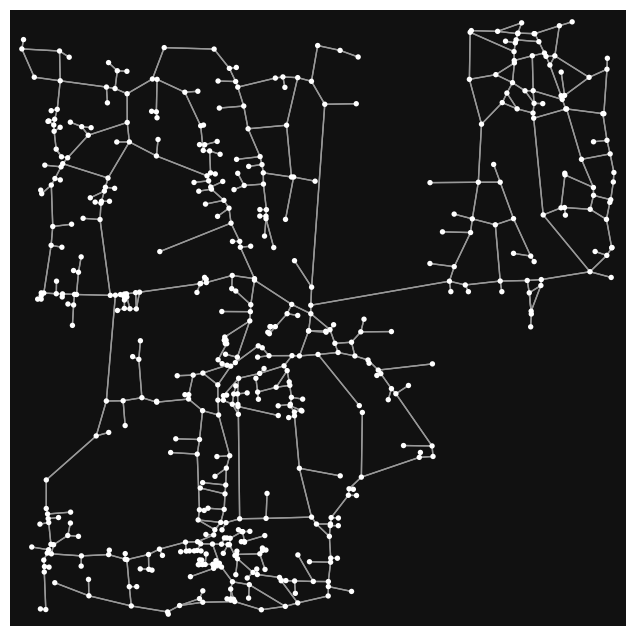

Graph of street network within a 3300 meter radius of Gomnati Primary School: MultiDiGraph with 562 nodes and 1278 edges


In [62]:
# Retrieve the map of Gomnati village using Gomnati Primary School as the center point
# We overwrite the in-memory OSMnx graph as the tools refer to this variable name specifically
G_ox = ox.graph_from_point((26.195655, 88.852847), dist=3500.00)

for node1, node2, edge_dict in G_ox.edges(data=True):
    edge_dict.pop('geometry', None)

ox.plot_graph(G_ox)
print(f"Graph of street network within a 3300 meter radius of Gomnati Primary School: {G_ox}")

In [63]:
# Since the nodes in the OSMnx graph do not include the address, we geocode each node
geolocator = Nominatim(user_agent="osmnx_geocoder")
for node_id, node_data in G_ox.nodes(data=True):
    lat = node_data['y']
    lon = node_data['x']
    
    try:
        # Use reverse geocoding on points to get address information
        location = geolocator.reverse(f"{lat}, {lon}", exactly_one=True, timeout=None)
        if location:
            # Add address information to the node
            G_ox.nodes[node_id]['address'] = location.address

        # Avoid possible rate limiting by waiting a bit between each node
        time.sleep(1)
        
    except Exception as e:
        print(f"Error geocoding node {node_id}: {e}")

In [64]:
for node_id, node_data in G_ox.nodes(data=True):
    G_ox.nodes[node_id]['ID'] = node_id

In [72]:
gomnati_filepath = "./data/gomnati.graphml"

In [66]:
ox.io.save_graphml(G_ox, gomnati_filepath)

In [73]:
G_ox = ox.io.load_graphml(gomnati_filepath)

In [67]:
node_list_with_addresses = list(G_ox.nodes(data=True))
print(f"Sample node data with address: {node_list_with_addresses[0]}")
print(f"Sample node data with address: {node_list_with_addresses[65]}")
print(f"Sample node data with address: {node_list_with_addresses[82]}")
print(f"Sample node data with address: {node_list_with_addresses[34]}")

edge_list = list(G_ox.edges(data=True))
print(f"Sample edge data: {edge_list [0]}")
print(f"Sample edge data: {edge_list [65]}")
print(f"Sample edge data: {edge_list [120]}")
print(f"Sample edge data: {edge_list [34]}")

Sample node data with address: (2543013892, {'y': 26.1961017, 'x': 88.8520091, 'street_count': 4, 'address': 'ডোমার উপজেলা, নীলফামারী জেলা, রংপুর বিভাগ, 5351, বাংলাদেশ', 'ID': 2543013892})
Sample node data with address: (5236364204, {'y': 26.2176575, 'x': 88.8212908, 'street_count': 1, 'address': 'ডোমার উপজেলা, নীলফামারী জেলা, রংপুর বিভাগ, বাংলাদেশ', 'ID': 5236364204})
Sample node data with address: (5236380100, {'y': 26.2128542, 'x': 88.83374, 'street_count': 3, 'address': 'Z5706, ডোমার উপজেলা, নীলফামারী জেলা, রংপুর বিভাগ, বাংলাদেশ', 'ID': 5236380100})
Sample node data with address: (4636741020, {'y': 26.2164084, 'x': 88.8302877, 'street_count': 3, 'address': 'ডোমার উপজেলা, নীলফামারী জেলা, রংপুর বিভাগ, বাংলাদেশ', 'ID': 4636741020})
Sample edge data: (2543013892, 4620092601, {'osmid': 467378170, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': 318.90178393342154})
Sample edge data: (4636740731, 5468834888, {'osmid': 469324308, 'highway': 'unclassified', 'oneway':

In [68]:
tags = {'building': True, 'amenity': True, 'healthcare': True, 'office': True, 'public_transport': True, 'craft': True, 'historic': True}
features_gdf = ox.features.features_from_point((26.200, 88.850), tags, dist=3500.00)

In [69]:
utm_crs = ox.projection.project_gdf(features_gdf).crs
features_gdf['lat'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).y
features_gdf['lon'] = features_gdf.to_crs(utm_crs).centroid.to_crs(features_gdf.crs).x
features_gdf_adjusted = features_gdf.drop(columns=['geometry'])

features_json_str = features_gdf_adjusted.reset_index().to_json(orient='records')
features_records = json.loads(features_json_str)

for feature in features_records:
    for key, value in list(feature.items()):
        if value is None:
            del feature[key]

print(f"Sample feature data: {features_records[0]}\n")
print(f"Sample feature data: {features_records[1]}\n")
print(f"Sample feature data: {features_records[2]}\n")

Sample feature data: {'element': 'node', 'id': 6367303389, 'amenity': 'marketplace', 'name': 'চৌরঙ্গী বাজার', 'lat': 26.1997535, 'lon': 88.8687129}

Sample feature data: {'element': 'node', 'id': 6450148614, 'amenity': 'place_of_worship', 'name': 'আদর্শ বাজার মসজিদ', 'religion': 'muslim', 'lat': 26.2188201, 'lon': 88.8822645}

Sample feature data: {'element': 'node', 'id': 6458769988, 'amenity': 'college', 'name': 'গোমনাতি মহাবিদ্যালয়', 'lat': 26.198222, 'lon': 88.8525268}



To augment the potential of our insights, let's pull in some critical data. https://healthsites.io/ was created by the Global Healthsites Mapping Project, with the aim of making global health facility data open and accessible. They have per-country datasets that can be retrieved via their API or downloadable as geospatial files.

In [70]:
# Downloaded the Bangladesh healthsites data as a Shapefile from healthsites.io
# Load this into a GeoDataFrame to access Point data
bd_healthsites_df = gpd.read_file('data/Bangladesh-node.shp')

In [71]:
# There are no Polygon shapes in this dataset, just points, so not need to use centroids
bd_healthsites_df['lon'] = bd_healthsites_df.geometry.apply(lambda p: p.x)
bd_healthsites_df['lat'] = bd_healthsites_df.geometry.apply(lambda p: p.y)

# Drop the geometry, duplicate, and empty columns that prevent serialization
bd_healthsites_df_adjusted = bd_healthsites_df.drop(columns=['geometry','is_in_heal','changeset_'])
bd_healthsites_json_str = bd_healthsites_df_adjusted.reset_index().to_json(orient='records')
bd_healthsites_records = json.loads(bd_healthsites_json_str)

print(f"Sample healthsite data: {bd_healthsites_records[0]}\n")
print(f"Sample healthsite data: {bd_healthsites_records[1]}\n")
print(f"Sample healthsite data: {bd_healthsites_records[2]}\n")

Sample healthsite data: {'index': 0, 'osm_id': '354463524', 'amenity': 'hospital', 'healthcare': 'hospital', 'name': 'à¦ªà¦¿à¦\x9cà¦¿ à¦¹à¦¾à¦¸à¦ªà¦¾à¦¤à¦¾à¦²', 'operator': None, 'source': None, 'speciality': None, 'operator_t': None, 'contact_nu': None, 'operationa': None, 'opening_ho': None, 'beds': None, 'staff_doct': None, 'staff_nurs': None, 'health_ame': None, 'dispensing': None, 'wheelchair': None, 'emergency': None, 'insurance': None, 'water_sour': None, 'electricit': None, 'url': None, 'addr_house': None, 'addr_stree': None, 'addr_postc': None, 'addr_city': None, 'lon': 90.3955526356, 'lat': 23.7391178324}

Sample healthsite data: {'index': 1, 'osm_id': '1749628052', 'amenity': 'pharmacy', 'healthcare': None, 'name': 'Comfort Hotel', 'operator': None, 'source': None, 'speciality': None, 'operator_t': None, 'contact_nu': None, 'operationa': None, 'opening_ho': None, 'beds': None, 'staff_doct': None, 'staff_nurs': None, 'health_ame': None, 'dispensing': None, 'wheelchair': None,

In [75]:
# Create the database to store graph and features collection for Gomnati
if not sys_db.has_database('gomnati'):
    sys_db.create_database('gomnati')

gomnati_db = client.db('gomnati',username=adb_user,password=adb_pass,verify=True)

In [80]:
G_ox_adb = nxadb.MultiDiGraph(
    name="G_ox_adb",
    db=gomnati_db,
    incoming_graph_data=G_ox,
    overwrite_graph=True
)
print(f"Graph of Gomnati, Bangladesh rural network persisted to ArangoDB: {G_ox_adb}")

print(f"True number of nodes in G_ox_adb is: {G_ox_adb.number_of_nodes()}")
print(f"True number of edges in G_ox_adb is: {G_ox_adb.number_of_edges()}")

[11:22:34 -0500] [INFO]: Overwriting graph 'G_ox_adb'
[11:22:34 -0500] [INFO]: Graph 'G_ox_adb' exists.
[11:22:34 -0500] [INFO]: Default node type set to 'G_ox_adb_node'
[2025/03/08 11:22:34 -0500] [1785] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'gomnati'


Output()

Output()

[2025/03/08 11:22:34 -0500] [1785] [INFO] - adbnx_adapter: Created ArangoDB 'G_ox_adb' Graph


Graph of Gomnati, Bangladesh rural network persisted to ArangoDB: MultiDiGraph named 'G_ox_adb' with 562 nodes and 0 edges
True number of nodes in G_ox_adb is: 562
True number of edges in G_ox_adb is: 1278


In [78]:
if gomnati_db.has_collection('features'):
    gomnati_db.delete_collection('features')
features_collection = gomnati_db.create_collection('features')

features_collection.insert_many(features_records)
print(f"Added {len(features_records)} feature records to ArangoDB 'features' collection in the Gomnati database")

Added 464 feature records to ArangoDB 'features' collection in the Gomnati database


In [75]:
if gomnati_db.has_collection('healthsites'):
    gomnati_db.delete_collection('healthsites')
healthsites_collection = gomnati_db.create_collection('healthsites')

healthsites_collection.insert_many(bd_healthsites_records)
print(f"Added {len(bd_healthsites_records)} feature records to ArangoDB 'features' collection in the Gomnati database")

Added 6437 feature records to ArangoDB 'features' collection in the Gomnati database


In [81]:
# Initialize ArangoGraph for the Gomnati database
arango_graph = ArangoGraph(gomnati_db)

In [77]:
query_street_network("What is the shortest path to the nearest health facility to গোমনাতি মহাবিদ্যালয়?")

📍 GEOCODER: Processing query: 'গোমনাতি মহাবিদ্যালয়'
📍 GEOCODER: Initialized LLM
📍 GEOCODER: Extracted locations: ['গোমনাতি মহাবিদ্যালয়']
📍 GEOCODER: Found গোমনাতি মহাবিদ্যালয় at 26.198222, 88.8525268
📍 GEOCODER: Identified primary location: গোমনাতি মহাবিদ্যালয়, Shahid Zia Road, Domar Upazila, Nilphamari District, Rangpur Division, Bangladesh ✅
🔍 AQL Tool: Starting to process query: 'FOR facility IN health_facilities
LET distance = GEO_DISTANCE([88.8525268, 26.198222], [facility.longitude, facility.latitude])
SORT distance ASC
LIMIT 1
RETURN {name: facility.name, latitude: facility.latitude, longitude: facility.longitude, distance: distance}'
🔍 AQL Tool: Initialized LLM
🔍 AQL Tool: Executing query against ArangoDB


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH G_ox_adb_node, healthsites
FOR facility IN healthsites
    LET distance = GEO_DISTANCE([88.8525268, 26.198222], [facility.lon, facility.lat])
    SORT distance ASC
    LIMIT 1
    RETURN {name: facility.name, lat

The shortest path from গোমনাতি মহাবিদ্যালয় to দক্ষিণ বালাপাড়া কমিউনিটি ক্লিনিক is approximately 5.06 kilometers when using the street network. This route provides the most efficient travel option between these two locations.

In [85]:
query_street_network("Visualize the three most isolated addresses in this street network.")

🚏 OSMnx Tool: Starting to process query: 'Find the three most isolated nodes in the street network using closeness centrality.'
🚏 OSMnx Tool: Initialized LLM
🚏 OSMnx Tool: 1) Generating OSMnx code
🚏 OSMnx Tool: Generated code:
--------------------------------------------------
import networkx as nx
import osmnx as ox

# Calculate closeness centrality for all nodes in the graph
closeness_centrality = nx.closeness_centrality(G_ox)

# Sort nodes by closeness centrality in ascending order to find the most isolated nodes
sorted_nodes = sorted(closeness_centrality.items(), key=lambda item: item[1])

# Get the three most isolated nodes (with the lowest closeness centrality)
most_isolated_nodes = sorted_nodes[:3]

# Prepare the final result with node IDs and their closeness centrality values
FINAL_RESULT = [{"node_id": node, "closeness_centrality": round(centrality, 6)} for node, centrality in most_isolated_nodes]
--------------------------------------------------

🚏 OSMnx Tool: 2) Executing O

The map visualizing the three most isolated addresses in the street network has been created. You can view the locations on the map, which are marked with their respective addresses.